# This notebook analyses the performance the CNN model, and compares it with the KNN. 

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

thumbNail.csv
vein.csv
earLobe.csv
innerArm.csv


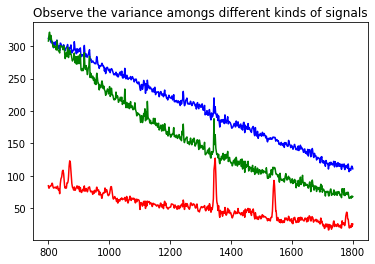

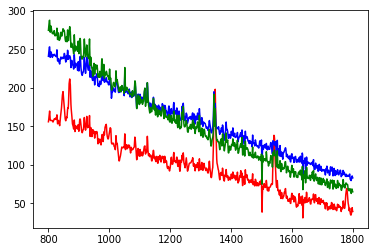

In [2]:
from ..reading_raman import *

In [3]:
## LOAD the data and reshape 
X = ramandata_raw_final
Y = diabetes
nchannels = 1
rows = X.shape[1]

x_train = X.astype('float32')
x_train = x_train.reshape((-1, nchannels, rows))
targets_train=Y.astype('int32')

print("Information on dataset")
print("X_train shape : ", x_train.shape)
print("Y shape : ", Y.shape)
print("X dtype, Y dtype :", x_train.dtype, targets_train.dtype)

Information on dataset
X_train shape :  (80, 1, 1001)
Y shape :  (80,)
X dtype, Y dtype : float32 int32


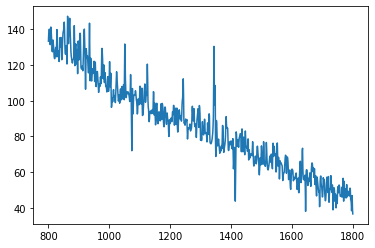

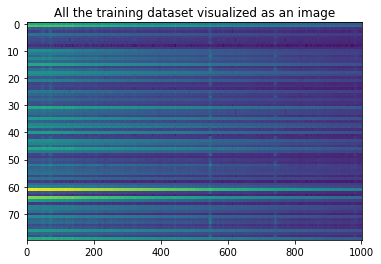

In [4]:
spectrum = x_train[2, 0, :]
Shift_values = np.linspace(800, 1800, 1001)
plt.plot(Shift_values, spectrum)
plt.show()
plt.title('All the training dataset visualized as an image')
plt.imshow(x_train[:, 0, :], aspect='auto')

# Define the neural network, retrain the neural network and measure performance

In [5]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, BatchNorm1d, Conv1d, MaxPool1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [6]:
# hyperameters of the model from hyperparameter search
num_classes = 2
channels = x_train.shape[1]
height = x_train.shape[2]

num_filters_conv1 = 4
kernel_size_conv1 = 8 
stride_conv1 = 7
padding_conv1 = 0

   
def compute_conv_dim(dim_size, k, p, s):
    return int((dim_size - k + 2 * p) / s + 1)
    
def compute_pool_dim(dim_size, kp, pp, sp):
    return int((dim_size - kp + 2 * pp) / sp + 1)


# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             padding=padding_conv1,
                             stride=stride_conv1)
        self.conv_1_bn = BatchNorm1d(num_filters_conv1)
        
        self.conv_out_height = compute_conv_dim(height, kernel_size_conv1, padding_conv1, 
                                                                 stride_conv1)
        
        #inplace initialisation of the network
        torch.nn.init.normal_(self.conv_1.weight,mean=0,std=0.22)

        
        self.l1_in_features = num_filters_conv1 * self.conv_out_height 
        
        
        self.l_out = Linear(in_features=self.l1_in_features, 
                            out_features=num_classes,
                            bias=True)
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = relu(self.conv_1_bn(self.conv_1(x))) 
        x = x.view(-1, self.l1_in_features)
        return softmax(self.l_out(x), dim=1)
    
net = Net()
print(net)

Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [8]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (5, 1, 1001)).astype('float32')
#print(x.shape)
out = net(Variable(torch.from_numpy(x)))
out.size(), out, out.dtype

(torch.Size([5, 2]), tensor([[0.4680, 0.5320],
         [0.4609, 0.5391],
         [0.4332, 0.5668],
         [0.5473, 0.4527],
         [0.5593, 0.4407]], grad_fn=<SoftmaxBackward>), torch.float32)

In [9]:
from sklearn.metrics import accuracy_score
def train_model(x_train, x_valid, targets_train, targets_valid, epochsnum):
    """
    Trains the neural network, and returns lists of losses on the training and validation set, every 
    epoch, and also the predictions made by the network. All this is packed as a tuple when returning.
    """
    batch_size = 8
    num_epochs = epochsnum
    num_samples_train = x_train.shape[0]
    num_batches_train = int(np.ceil(num_samples_train / float(batch_size)))
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = int(np.ceil(num_samples_valid / float(batch_size)))

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    test_acc, test_loss = [], []
    cur_loss = 0
    losses = []
    losses_train=[]
    losses_valid = []


    #creating a numpy array to store the output probabilities
    output_probs = np.ones((1, 3), dtype=np.float32)

    #get_slice = lambda i, size,num_samples: range(i * size, (i + 1) * size)
    get_slice = lambda i, size, num_samples: range(i * size, np.minimum((i + 1) * size,num_samples))
    for epoch in range(num_epochs):
        cur_loss = 0
        net.train()
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size, num_samples_train)
            x_batch = Variable(torch.from_numpy(x_train[slce]))
            output = net(x_batch)

            # compute gradients given loss
            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            cur_loss += batch_loss.data.numpy()   
        losses.append(cur_loss / num_batches_train)

        net.eval()
        #Evaluating training
        train_preds, train_targs = [], []
        cur_loss=0
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size, num_samples_train)
            x_batch = Variable(torch.from_numpy(x_train[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            train_targs += list(targets_train[slce])
            train_preds += list(preds.data.numpy())

            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)

            cur_loss += batch_loss.data.numpy()
        losses_train.append(cur_loss / num_batches_train)

        ### Evaluate validation
        val_preds, val_targs = [], []
        cur_loss = 0
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size, num_samples_valid)
            x_batch = Variable(torch.from_numpy(x_valid[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            val_preds += list(preds.data.numpy())
            val_targs += list(targets_valid[slce])

            target_batch = Variable(torch.from_numpy(targets_valid[slce]).long())
            batch_loss = criterion(output, target_batch)         
            cur_loss += batch_loss.data.numpy()
        losses_valid.append(cur_loss / num_batches_valid)


            #Taking the output probabilities and storing them in a numpy array
            #output_probs=np.append(output_probs,output.data.numpy(),axis=0)

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

    epoch = np.arange(len(train_acc))
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Acc', 'Val Acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.show()

    plt.figure()
    plt.plot(losses_train,'r')
    plt.plot(losses_valid,'b')
    plt.legend(['Train','Valid'])
    plt.show()
    return (val_targs,val_preds,losses_train,losses_valid)

In [10]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.3912, 0.6088],
        [0.4827, 0.5173],
        [0.5700, 0.4300],
        [0.6573, 0.3427],
        [0.3679, 0.6321]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.707086 , Train acc 0.492063, Valid acc 0.352941
Epoch 11 : Train Loss 0.641403 , Train acc 0.619048, Valid acc 0.588235
Epoch 21 : Train Loss 0.541098 , Train acc 0.873016, Valid acc 0.529412
Epoch 31 : Train Loss 0.454920 , Train acc 0.920635, Valid acc 0.705882
Epoch 41 : Train Loss 0.402887 , Train acc 0.984127, Valid acc 0.705882
Epoch 51 : Train Loss 0.374684 , Train acc 0.984127, Valid acc 0.823529
Epoch 61 : Train Loss 0.358239 , Train acc 0.984127, Valid acc 0.823529
Epoch 71 : Train Loss 0.349232 , Train acc 1.000000, Valid acc 0.823529
Epoch 81 : Tra

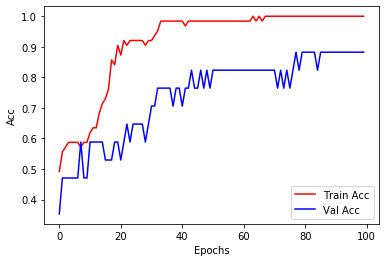

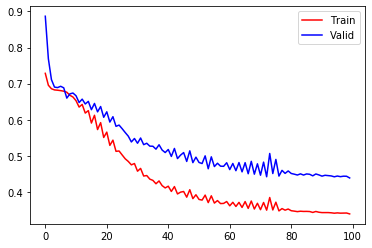

[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4055, 0.5945],
        [0.4910, 0.5090],
        [0.4677, 0.5323],
        [0.3814, 0.6186],
        [0.4748, 0.5252]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.698453 , Train acc 0.437500, Valid acc 0.687500
Epoch 11 : Train Loss 0.576760 , Train acc 0.843750, Valid acc 0.750000
Epoch 21 : Train Loss 0.468599 , Train acc 0.937500, Valid acc 0.937500
Epoch 31 : Train Loss 0.405841 , Train acc 1.000000, Valid acc 0.937500
Epoch 41 : Train Loss 0.374544 , Train acc 1.000000, Valid acc 0.937500
Epoch 51 : Train Loss 

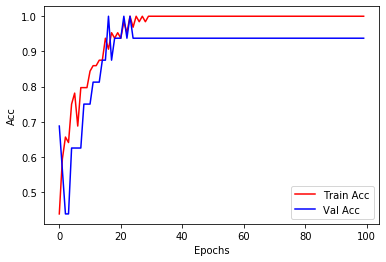

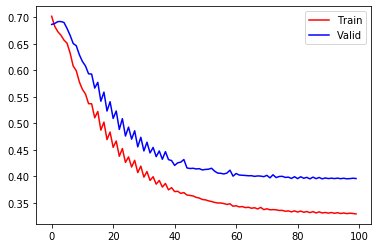

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.6567, 0.3433],
        [0.5679, 0.4321],
        [0.6266, 0.3734],
        [0.5183, 0.4817],
        [0.6838, 0.3162]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.703959 , Train acc 0.625000, Valid acc 0.562500
Epoch 11 : Train Loss 0.632647 , Train acc 0.734375, Valid acc 0.312500
Epoch 21 : Train Loss 0.552521 , Train acc 0.875000, Valid acc 0.812500
Epoch 31 : Train Loss 0.481772 , Train acc 0.921875, Valid acc 0.812500
Epoc

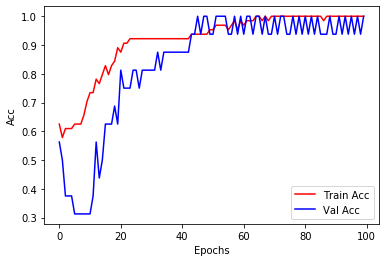

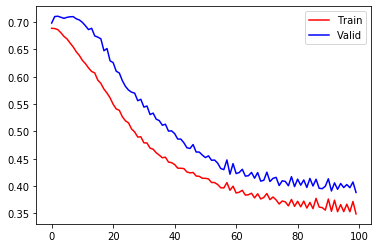

[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4932, 0.5068],
        [0.5106, 0.4894],
        [0.4805, 0.5195],
        [0.4310, 0.5690],
        [0.5542, 0.4458]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.702964 , Train acc 0.484375, Valid acc 0.375000
Epoch 11 : Train Loss 0.675673 , Train acc 0.578125, Valid acc 0.500000
Epoch 21 : Train Loss 0.550471 , Train acc 0.859375,

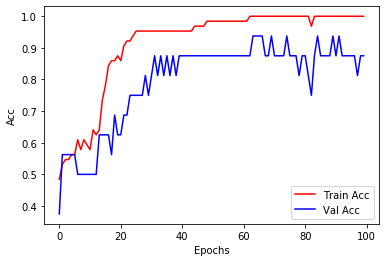

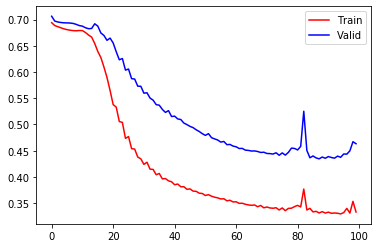

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4407, 0.5593],
        [0.4506, 0.5494],
        [0.4775, 0.5225],
        [0.3133, 0.6867],
        [0.4829, 0.5171]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.711545 , Train acc 0.523077, Valid acc 0.600000
Epoch 11 : Train Loss 0.5504

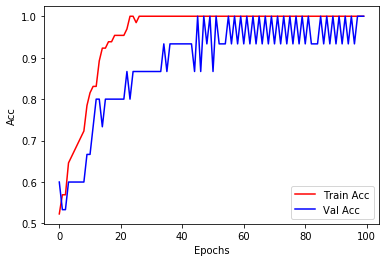

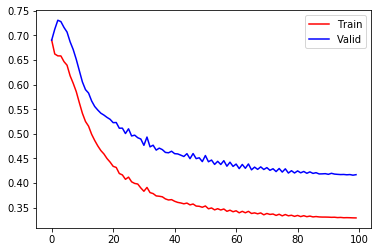

[0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]


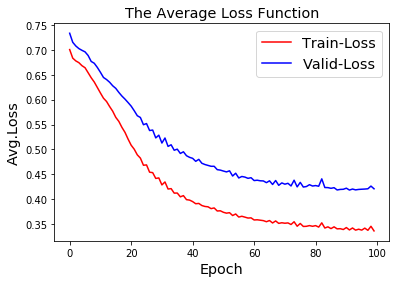

0.9375


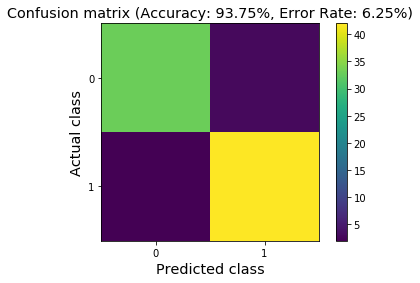

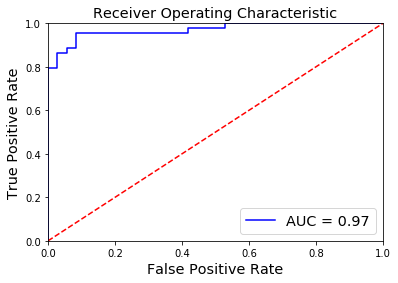

In [12]:
# Cross Validation to get an unbiased estimate of the models generalisation error.
cv = StratifiedKFold(n_splits=5)
Validation_Targets = []
Validation_Preds = []
Total_Loss_Train = np.zeros(100)
Total_Loss_Valid = np.zeros(100)
All_Probabilities = []
for train,test in cv.split(x_train, targets_train):
    Train_Data = x_train[train]
    Train_targets = targets_train[train]
    Test_Data = x_train[test]
    Test_targets = targets_train[test]
    net = Net()
    print(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
    x = np.random.normal(0,1, (5, 1, 1001)).astype('float32')
    #print(x.shape)
    out = net(Variable(torch.from_numpy(x)))
    print(out.size(), out, out.dtype)
    val_targs, val_preds, losses_train, losses_valid = train_model(Train_Data, Test_Data, Train_targets, Test_targets, 100)
    print(val_preds)
    print(val_targs)
    Validation_Targets += list(val_targs)
    Validation_Preds += list(val_preds)
    print(Validation_Targets) 
    print(Validation_Preds) 
    Losses_Train_Array = np.asarray(losses_train)
    Losses_Valid_Array = np.asarray(losses_valid)
    Total_Loss_Train = Total_Loss_Train + Losses_Train_Array
    Total_Loss_Valid = Total_Loss_Valid + Losses_Valid_Array
    Preds_Probabilities = net(Variable(torch.from_numpy(Test_Data))).data.numpy()
    All_Probabilities += list(Preds_Probabilities[:,1])

plt.figure()
plt.title('The Average Loss Function', fontsize='x-large')
plt.plot(Total_Loss_Train/5, 'r')
plt.plot(Total_Loss_Valid/5, 'b')
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Avg.Loss', fontsize='x-large')
plt.legend(['Train-Loss','Valid-Loss'], fontsize='x-large')
plt.savefig('Images/LossFunction_CNN_ShallowNetwork_rawData.png')
plt.show()

print(accuracy_score(Validation_Targets, Validation_Preds))

# Computing the confusion matrix and the AUC-ROC plot
from sklearn.metrics import confusion_matrix

C = num_classes
cm = confusion_matrix(Validation_Targets, Validation_Preds);
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
plt.figure(2);
plt.imshow(cm, interpolation='None');
plt.colorbar()
plt.xticks(range(C)); plt.yticks(range(C));
plt.xlabel('Predicted class', fontsize='x-large'); plt.ylabel('Actual class', fontsize='x-large');
plt.title('Confusion matrix (Accuracy: {:4.2f}%, Error Rate: {:4.2f}%)'.format(accuracy, error_rate), fontsize='x-large');
plt.savefig('Images/ConfusionMatrix_CNN_ShallowNetwork_rawData.png')
plt.show()

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Validation_Targets, All_Probabilities)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic',fontsize='x-large')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize='x-large')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.savefig('Images/ROCCurve_CNN_ShallowNetwork_rawData.png')
plt.show()

    

In [13]:
cm

array([[33,  3],
       [ 2, 42]])

# Comparing the KNN classifier and the CNN model using the student-t 's test

CV-fold 1 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.703518 , Train acc 0.444444, Valid acc 0.500000
Epoch 11 : Train Loss 0.670676 , Train acc 0.569444, Valid acc 0.500000
Epoch 21 : Train Loss 0.572158 , Train acc 0.847222, Valid acc 0.875000
Epoch 31 : Train Loss 0.475308 , Train acc 0.958333, Valid acc 1.000000
Epoch 41 : Train Loss 0.424114 , Train acc 0.972222, Valid acc 1.000000
Epoch 51 : Train Loss 0.395715 , Train acc 0.972222, Valid acc 1.000000
Epoch 61 : Train Loss 0.377601 , Train acc 0.986111, Valid acc 1.000000
Epoch 71 : Train Loss 0.365352 , Train acc 1.000000, Valid acc 1.000000
Epoch 81 : Train Loss 0.356580 , Train acc 1.000000, Valid acc 1.000000
Epoch 91 : Train Loss 0.350140 , Train acc 1.000000, Valid acc 1.000000


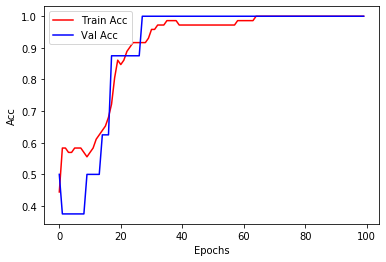

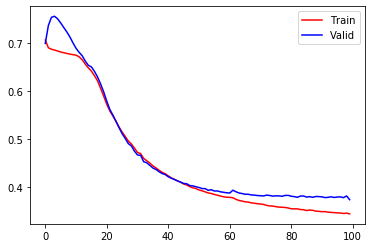

CV-fold 2 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.699519 , Train acc 0.458333, Valid acc 0.625000
Epoch 11 : Train Loss 0.626311 , Train acc 0.819444, Valid acc 0.375000
Epoch 21 : Train Loss 0.479935 , Train acc 0.930556, Valid acc 0.750000
Epoch 31 : Train Loss 0.408146 , Train acc 0.958333, Valid acc 0.750000
Epoch 41 : Train Loss 0.374362 , Train acc 0.986111, Valid acc 0.875000
Epoch 51 : Train Loss 0.356622 , Train acc 1.000000, Valid acc 0.875000
Epoch 61 : Train Loss 0.346140 , Train acc 1.000000, Valid acc 0.875000
Epoch 71 : Train Loss 0.339717 , Train acc 1.000000, Valid acc 0.875000
Epoch 81 : Train Loss 0.335673 , Train acc 1.000000, Valid acc 0.875000
Epoch 91 : Train Loss 0.332929 , Train acc 1.000000, Valid acc 0.875000


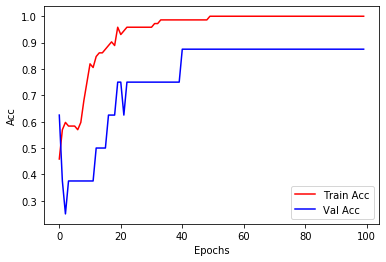

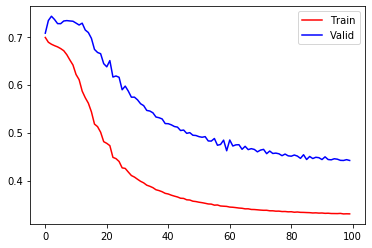

CV-fold 3 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.711565 , Train acc 0.458333, Valid acc 0.375000
Epoch 11 : Train Loss 0.652535 , Train acc 0.625000, Valid acc 0.500000
Epoch 21 : Train Loss 0.577801 , Train acc 0.833333, Valid acc 0.625000
Epoch 31 : Train Loss 0.488527 , Train acc 0.916667, Valid acc 0.625000
Epoch 41 : Train Loss 0.430545 , Train acc 0.958333, Valid acc 0.875000
Epoch 51 : Train Loss 0.394519 , Train acc 0.986111, Valid acc 0.875000
Epoch 61 : Train Loss 0.373459 , Train acc 1.000000, Valid acc 0.875000
Epoch 71 : Train Loss 0.360048 , Train acc 1.000000, Valid acc 1.000000
Epoch 81 : Train Loss 0.350872 , Train acc 1.000000, Valid acc 1.000000
Epoch 91 : Train Loss 0.344548 , Train acc 1.000000, Valid acc 0.875000


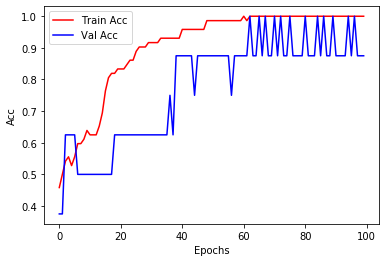

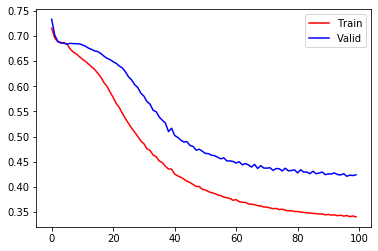

CV-fold 4 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.716636 , Train acc 0.458333, Valid acc 0.375000
Epoch 11 : Train Loss 0.653142 , Train acc 0.694444, Valid acc 0.625000
Epoch 21 : Train Loss 0.532653 , Train acc 0.902778, Valid acc 0.750000
Epoch 31 : Train Loss 0.422261 , Train acc 0.986111, Valid acc 0.875000
Epoch 41 : Train Loss 0.379236 , Train acc 1.000000, Valid acc 0.875000
Epoch 51 : Train Loss 0.357476 , Train acc 1.000000, Valid acc 0.875000
Epoch 61 : Train Loss 0.344713 , Train acc 1.000000, Valid acc 0.875000
Epoch 71 : Train Loss 0.337815 , Train acc 1.000000, Valid acc 0.875000
Epoch 81 : Train Loss 0.333904 , Train acc 1.000000, Valid acc 0.875000
Epoch 91 : Train Loss 0.331419 , Train acc 1.000000, Valid acc 0.875000


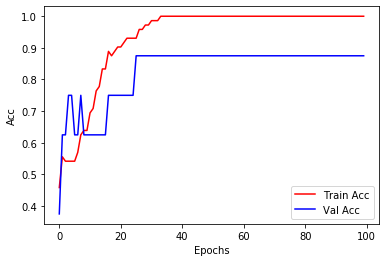

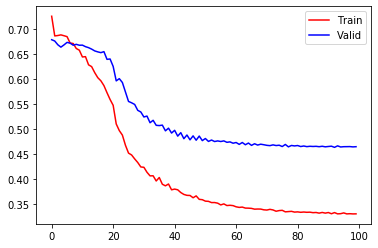

CV-fold 5 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.696926 , Train acc 0.416667, Valid acc 0.500000
Epoch 11 : Train Loss 0.626909 , Train acc 0.777778, Valid acc 0.625000
Epoch 21 : Train Loss 0.504731 , Train acc 0.930556, Valid acc 0.750000
Epoch 31 : Train Loss 0.428486 , Train acc 0.958333, Valid acc 0.875000
Epoch 41 : Train Loss 0.390839 , Train acc 0.972222, Valid acc 0.875000
Epoch 51 : Train Loss 0.368674 , Train acc 0.986111, Valid acc 0.875000
Epoch 61 : Train Loss 0.354119 , Train acc 1.000000, Valid acc 0.875000
Epoch 71 : Train Loss 0.344621 , Train acc 1.000000, Valid acc 0.875000
Epoch 81 : Train Loss 0.338679 , Train acc 1.000000, Valid acc 0.875000
Epoch 91 : Train Loss 0.335267 , Train acc 1.000000, Valid acc 0.875000


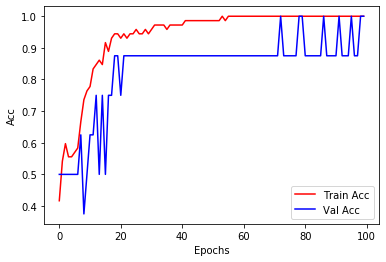

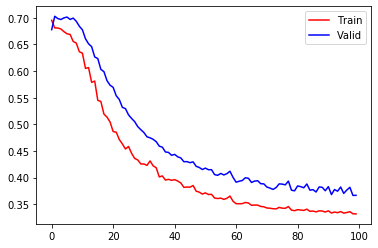

CV-fold 6 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.715716 , Train acc 0.472222, Valid acc 0.375000
Epoch 11 : Train Loss 0.674624 , Train acc 0.569444, Valid acc 0.625000
Epoch 21 : Train Loss 0.537869 , Train acc 0.930556, Valid acc 1.000000
Epoch 31 : Train Loss 0.419126 , Train acc 0.986111, Valid acc 1.000000
Epoch 41 : Train Loss 0.375782 , Train acc 1.000000, Valid acc 1.000000
Epoch 51 : Train Loss 0.355483 , Train acc 1.000000, Valid acc 1.000000
Epoch 61 : Train Loss 0.344207 , Train acc 1.000000, Valid acc 1.000000
Epoch 71 : Train Loss 0.337863 , Train acc 1.000000, Valid acc 1.000000
Epoch 81 : Train Loss 0.333906 , Train acc 1.000000, Valid acc 1.000000
Epoch 91 : Train Loss 0.331470 , Train acc 1.000000, Valid acc 1.000000


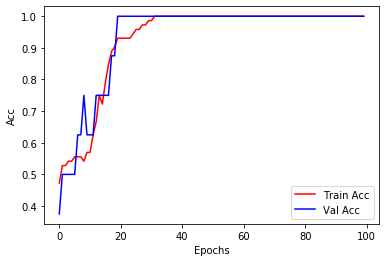

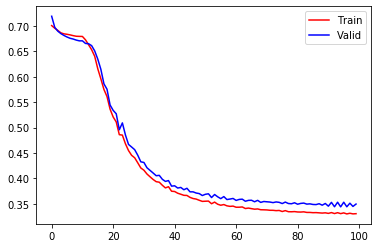

CV-fold 7 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.711686 , Train acc 0.444444, Valid acc 0.625000
Epoch 11 : Train Loss 0.631786 , Train acc 0.736111, Valid acc 0.625000
Epoch 21 : Train Loss 0.506818 , Train acc 0.916667, Valid acc 0.750000
Epoch 31 : Train Loss 0.433725 , Train acc 0.930556, Valid acc 0.875000
Epoch 41 : Train Loss 0.393014 , Train acc 0.972222, Valid acc 0.875000
Epoch 51 : Train Loss 0.369913 , Train acc 0.986111, Valid acc 0.875000
Epoch 61 : Train Loss 0.354073 , Train acc 1.000000, Valid acc 0.875000
Epoch 71 : Train Loss 0.345944 , Train acc 1.000000, Valid acc 0.875000
Epoch 81 : Train Loss 0.339536 , Train acc 1.000000, Valid acc 0.875000
Epoch 91 : Train Loss 0.334036 , Train acc 1.000000, Valid acc 0.875000


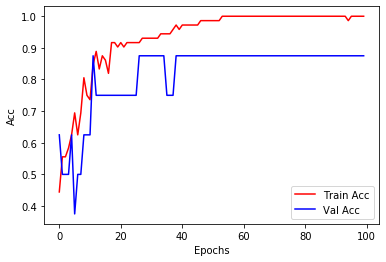

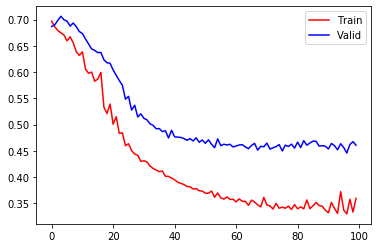

CV-fold 8 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.709288 , Train acc 0.458333, Valid acc 0.500000
Epoch 11 : Train Loss 0.681066 , Train acc 0.569444, Valid acc 0.625000
Epoch 21 : Train Loss 0.587472 , Train acc 0.847222, Valid acc 0.750000
Epoch 31 : Train Loss 0.449966 , Train acc 0.930556, Valid acc 0.875000
Epoch 41 : Train Loss 0.392573 , Train acc 0.958333, Valid acc 0.875000
Epoch 51 : Train Loss 0.365337 , Train acc 1.000000, Valid acc 1.000000
Epoch 61 : Train Loss 0.349959 , Train acc 1.000000, Valid acc 1.000000
Epoch 71 : Train Loss 0.340992 , Train acc 1.000000, Valid acc 1.000000
Epoch 81 : Train Loss 0.335639 , Train acc 1.000000, Valid acc 1.000000
Epoch 91 : Train Loss 0.332330 , Train acc 1.000000, Valid acc 1.000000


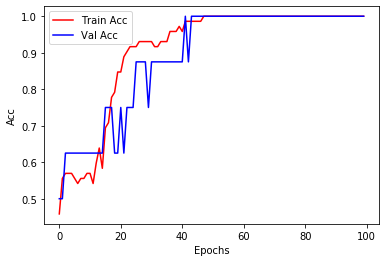

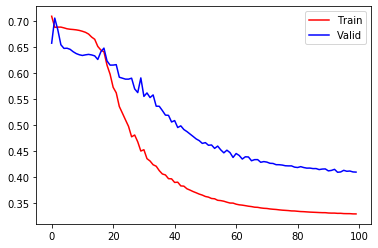

CV-fold 9 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.702590 , Train acc 0.500000, Valid acc 0.125000
Epoch 11 : Train Loss 0.668481 , Train acc 0.666667, Valid acc 0.625000
Epoch 21 : Train Loss 0.578847 , Train acc 0.861111, Valid acc 1.000000
Epoch 31 : Train Loss 0.494562 , Train acc 0.944444, Valid acc 1.000000
Epoch 41 : Train Loss 0.443986 , Train acc 0.944444, Valid acc 1.000000
Epoch 51 : Train Loss 0.411614 , Train acc 0.958333, Valid acc 1.000000
Epoch 61 : Train Loss 0.388824 , Train acc 0.972222, Valid acc 1.000000
Epoch 71 : Train Loss 0.373176 , Train acc 0.986111, Valid acc 1.000000
Epoch 81 : Train Loss 0.360706 , Train acc 1.000000, Valid acc 1.000000
Epoch 91 : Train Loss 0.352034 , Train acc 1.000000, Valid acc 1.000000


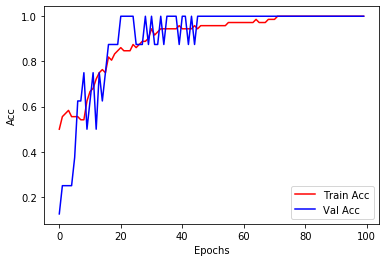

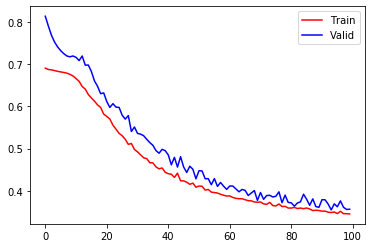

CV-fold 10 of 10
Net(
  (conv_1): Conv1d(1, 4, kernel_size=(8,), stride=(7,))
  (conv_1_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=568, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.709632 , Train acc 0.458333, Valid acc 0.375000
Epoch 11 : Train Loss 0.604288 , Train acc 0.777778, Valid acc 0.625000
Epoch 21 : Train Loss 0.474242 , Train acc 0.916667, Valid acc 0.750000
Epoch 31 : Train Loss 0.405928 , Train acc 1.000000, Valid acc 0.875000
Epoch 41 : Train Loss 0.373677 , Train acc 1.000000, Valid acc 0.875000
Epoch 51 : Train Loss 0.357269 , Train acc 1.000000, Valid acc 0.875000
Epoch 61 : Train Loss 0.346841 , Train acc 1.000000, Valid acc 0.875000
Epoch 71 : Train Loss 0.339245 , Train acc 1.000000, Valid acc 0.875000
Epoch 81 : Train Loss 0.335382 , Train acc 1.000000, Valid acc 0.875000
Epoch 91 : Train Loss 0.332592 , Train acc 1.000000, Valid acc 0.875000


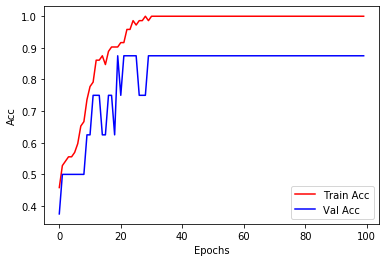

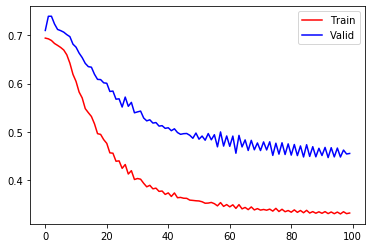

Classifiers are significantly different.


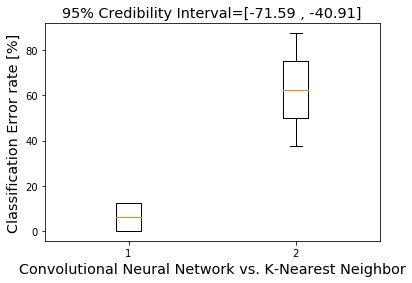

In [14]:
#Model Comparison 
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = KFold(n_splits=K)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_Cnn = np.empty((K,1))
Error_Knn = np.empty((K,1))
n_tested=0

k=0
for train_index, test_index in CV.split(x_train,targets_train):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = x_train[train_index,:]
    y_train = targets_train[train_index]
    X_test = x_train[test_index,:]
    y_test = targets_train[test_index]

    # Fit and evaluate CNN classifier
    net=Net()
    print(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=0.01)
    _,y_cnn,_,_=train_model(X_train,X_test,y_train,y_test,100)
    #model = lm.logistic.LogisticRegression(C=N)
    #model = model.fit(X_train, y_train)
    #y_logreg = model.predict(X_test)
    Error_Cnn[k] = 100*(y_cnn!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate K Nearest Neighbor classifier
    knclassifier = KNeighborsClassifier(n_neighbors=1);
    X_train=X_train.reshape((-1,rows))
    X_test=X_test.reshape((-1,rows))
    knclassifier.fit(X_train, y_train);
    y_knn = knclassifier.predict(X_test) ;
    #model2 = tree.DecisionTreeClassifier()
    #model2 = model2.fit(X_train, y_train)
    #y_dectree = model2.predict(X_test)
    Error_Knn[k] = 100*(y_knn!=y_test).sum().astype(float)/len(y_test)

    k+=1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_Cnn-Error_Knn)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
plt.figure()
plt.title('95% Credibility Interval=[{:4.2f} , {:4.2f}]'.format(zL,zH),fontsize='x-large')
plt.boxplot(np.concatenate((Error_Cnn, Error_Knn),axis=1))
plt.xlabel('Convolutional Neural Network vs. K-Nearest Neighbor',fontsize='x-large')
plt.ylabel('Classification Error rate [%]',fontsize='x-large')
plt.savefig('Images/CNN_KNN_Comparison_rawData.png')
plt.show()


# CODE FOR VISUALISING THE FILTERS AND THE FEATURE MAPS

In [ ]:
#CODE FOR VISUALISING THE FILTERS AND THE FEATURE MAPS
#Visualising the filters and the feature maps
#Taking a sample first
sample_spec = x_test[0]
print("The shape of sample spectrum",sample_spec.shape)
plt.plot(Shift_values,sample_spec[0,:])
sample_spec=sample_spec.reshape(-1,1,1001)
a=net(torch.from_numpy(sample_spec))
print("The output of the neural network is:",a.data)


In [ ]:
from torch.nn.functional import conv1d
input_tensor=torch.from_numpy(sample_spec)
filter1=net.conv_1.weight.data
Output_convolution=relu(net.conv_1_bn(net.conv_1(input_tensor)))
print("The Feature maps generated after the convolution operation is:",Output_convolution.shape)
print("The filters have a tensor size of",filter1.shape)
print("The Bias Term:",net.conv_1.bias.data)

In [ ]:
plt.figure()
plt.title('The Outputs of the convolutions')
for i in range(Output_convolution.shape[1]):
    plt.subplot(num_filters_conv1,1,i+1)
    plt.plot(Output_convolution[0,i,:].data.numpy())
plt.show()    

plt.figure()
plt.title("The Filters visualised on a graph")
for i in range(filter1.shape[0]):
    plt.title("")
    plt.subplot(num_filters_conv1,1,i+1)
    plt.plot(filter1[i,0,:].data.numpy())
plt.show()

In [ ]:
from scipy.signal import freqz

for i in range(filter1.shape[0]):
    w,h=freqz(filter1[i,0,:].data.numpy())
    plt.plot(w,20*np.log10(abs(h)),'b')
    plt.show()
    
print("This is the transfer function of the system")
print(type(sample_spec))
#w_input,h_input=freqz(sample_spec[0,0,:])
#plt.title("The input signal in the frequency domain")
#plt.plot(w_input,20*np.log10(abs(h_input)))